## Ref

- <https://pytorch-geometric-temporal.readthedocs.io/en/latest/modules/dataset.html#module-torch_geometric_temporal.dataset.chickenpox>

- <https://seoyeonc.github.io/blog/posts/GCN/2023-03-20-data%20load,%20data%20save%20as%20pickle.html#windmilloutputlargedatasetloader>

## import

In [2]:
import pandas as pd
import numpy as np
import json
import urllib

In [3]:
# 일반적인 모듈 
import numpy as np
import matplotlib.pyplot as plt 
import networkx as nx 
from tqdm import tqdm 

# 파이토치 관련 
import torch
import torch.nn.functional as F

# PyG 관련 
from torch_geometric.data import Data ## Data: 그래프자료형을 만드는 클래스

# STGCN 관련 
import torch_geometric_temporal
from torch_geometric_temporal.nn.recurrent import GConvGRU
from torch_geometric_temporal.signal import temporal_signal_split 

In [4]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

## WindmillOutputLargeDataset 살펴보기

> ***weighted edges***

Hourly energy output of windmills from a European country for more than 2 years. Vertices represent 319 windmills and weighted edges describe the strength of relationships. The target variable allows for regression tasks.

- $T = 17472$ 
- $V = $ 풍력발전소
- $N = $ 노드 수
- $E = 101761 = N^2$ 에지 수

${\bf f}=\begin{bmatrix} {\bf f}_1\\ {\bf f}_2\\ \dots \\ {\bf f}_{17472} \end{bmatrix}=\begin{bmatrix} f(t=1,v=\tt{V1}) & \dots & f(t=1,v=\tt{V319}) \\ f(t=2,v=\tt{V1}) & \dots & f(t=2,v=\tt{V319}) \\ \dots & \dots & \dots \\ f(t=17472,v=\tt{V1}) & \dots & f(t=17472,v=\tt{V319}) \end{bmatrix}$

In [5]:
url = "https://graphmining.ai/temporal_datasets/windmill_output.json"
data_dict = json.loads(urllib.request.urlopen(url).read())
data_dict.keys()

dict_keys(['block', 'time_periods', 'weights', 'edges'])

In [6]:
365*2*24 # 1년 365일 기준 하루 24시간 --> 17520시간.

17520

In [43]:
data_dict['time_periods']

17472

In [41]:
np.array(data_dict['block']).shape # fx

(17472, 319)

In [42]:
len(data_dict['weights'])

101761

In [11]:
np.array(data_dict['edges']).shape

(101761, 2)

In [28]:
319 ** 2

101761

In [14]:
np.array(data_dict['weights']).shape

(101761,)

In [24]:
np.array(data_dict['weights']).reshape(319, 319)

array([[1.        , 0.83313653, 0.76403123, ..., 0.03572003, 0.02756888,
        0.01799128],
       [0.83313653, 1.        , 0.91705372, ..., 0.03025762, 0.0241852 ,
        0.01583424],
       [0.76403123, 0.91705372, 1.        , ..., 0.02794797, 0.02269021,
        0.01487937],
       ...,
       [0.03572003, 0.03025762, 0.02794797, ..., 1.        , 0.29412671,
        0.21992883],
       [0.02756888, 0.0241852 , 0.02269021, ..., 0.29412671, 1.        ,
        0.64651593],
       [0.01799128, 0.01583424, 0.01487937, ..., 0.21992883, 0.64651593,
        1.        ]])

In [7]:
node_ids = {}
for i in range(319):
    node_ids['node' + str(i+1)] = i

In [8]:
edges = np.array(data_dict['edges']).T
edge_weight = np.array(data_dict['weights'])

## --

## WindmillOutputLargeDatasetLoader

ref: <https://github.com/benedekrozemberczki/pytorch_geometric_temporal/blob/master/docs/source/notes/introduction.rst>

In [9]:
torch_geometric_temporal.signal.StaticGraphTemporalSignal 

torch_geometric_temporal.signal.static_graph_temporal_signal.StaticGraphTemporalSignal

In [10]:
loader = torch_geometric_temporal.dataset.WindmillOutputLargeDatasetLoader()
dataset = loader.get_dataset(lags=4)
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

## Learn

In [12]:
model = RecurrentGCN(node_features=4, filters=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

for epoch in tqdm(range(50)):
    for t, snapshot in enumerate(train_dataset):
        yt_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = torch.mean((yt_hat-snapshot.y)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

  0%|                                                                                                              | 0/50 [00:26<?, ?it/s]


KeyboardInterrupt: 

- 학습이 매우 느림.. (8시50분시작 ..새벽 1시 20분에 끝남..4시간넘게 걸린다.)

## Visualization

In [69]:
model.eval()
cost = 0
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 1.0237


In [13]:
# yhat_train = torch.stack([model(snapshot.x,snapshot.edge_index, snapshot.edge_attr) for snapshot in train_dataset]).detach().numpy()
# yhat_test = torch.stack([model(snapshot.x,snapshot.edge_index, snapshot.edge_attr) for snapshot in test_dataset]).detach().numpy()

- 커널 죽음ㅠㅠㅠ (사이즈를 줄여서 해야할 듯.)

In [14]:
# V = list(node_ids)

NameError: name 'f' is not defined

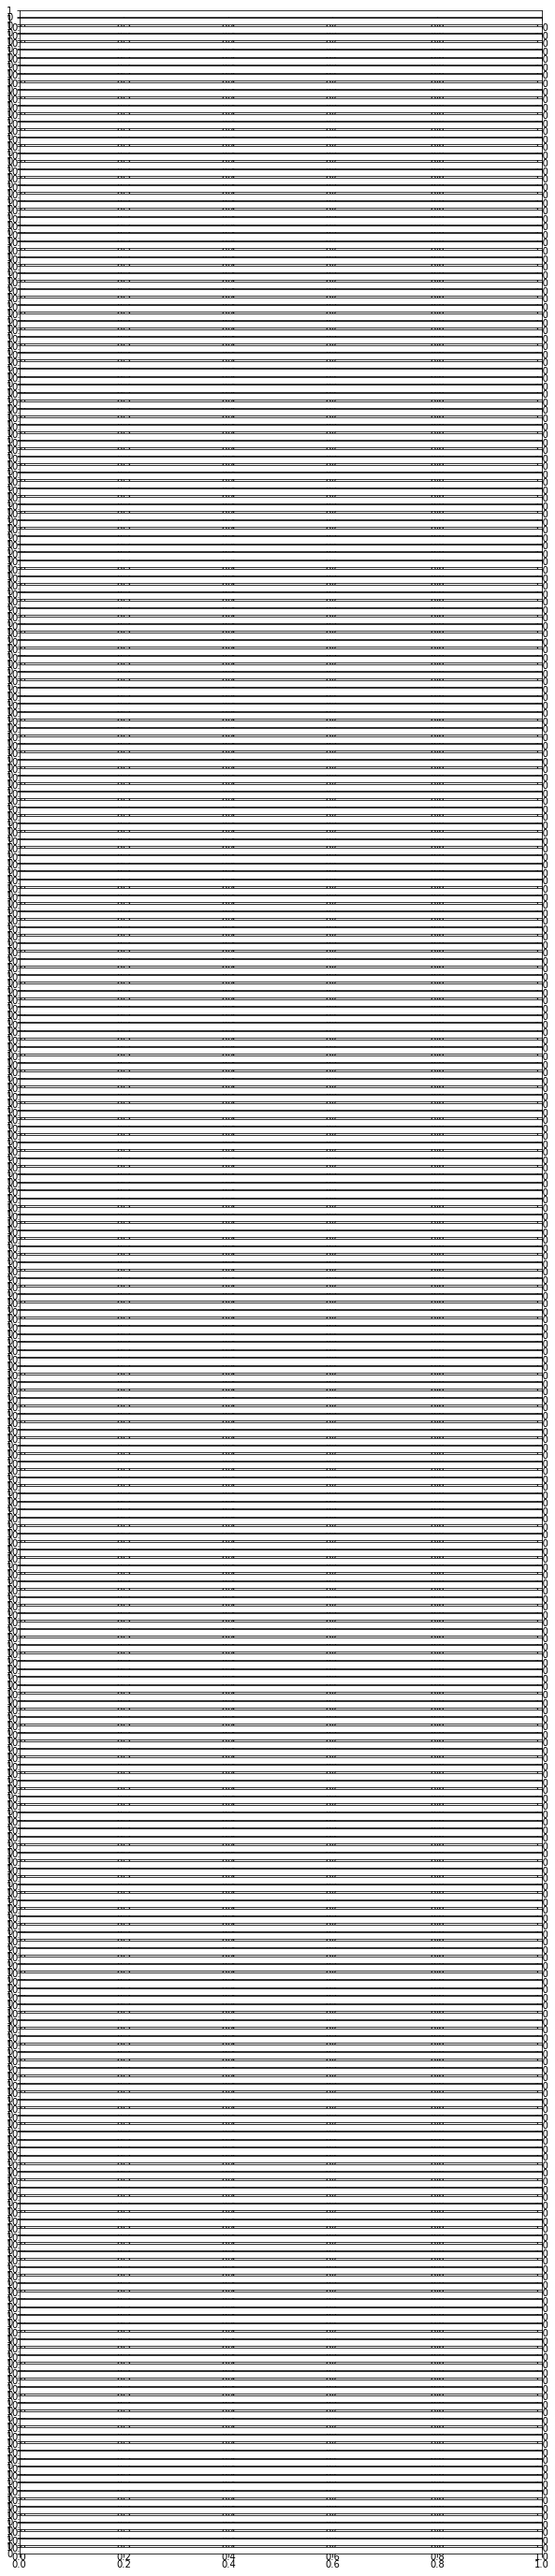

In [15]:
fig,ax = plt.subplots(319,1,figsize=(10,50))
for k in range(319):
    ax[k].plot(f[:,k],'--',alpha=0.5,label='observed')
    ax[k].set_title('node: {}'.format(V[k]))
    ax[k].plot(yhat_train[:,k],label='predicted (tr)')
    ax[k].plot(range(yhat_train.shape[0],yhat_train.shape[0]+yhat_test.shape[0]),yhat_test[:,k],label='predicted (test)')
    ax[k].legend()
# fig.tight_layout()